In [1]:
from json.tool import main
from preprocess import extract_lfcc, extract_mfcc
from GMM_breath import GMMClassifier, ClassifierValidator, VectorDataSource
import pickle
from auditok import DataValidator, ADSFactory, DataSource, StreamTokenizer, BufferAudioSource, player_for
import soundfile as sf
from IPython.display import display, Audio
from hparams import *

ModuleNotFoundError: No module named 'preprocess'

In [58]:
models = {}
for cls in ["breath", "silence", "speech"]:
    fp = open("out/{}.gmm".format(cls), "rb")
    models[cls]=pickle.load(fp)
    fp.close()

gmm_classifier = GMMClassifier(models)

silence_validator = ClassifierValidator(gmm_classifier, "silence")
speech_validator = ClassifierValidator(gmm_classifier, "speech")
breath_validator = ClassifierValidator(gmm_classifier, "breath")
# Tokennizer
analysis_window_per_second = 1. / ANALYSIS_STEP
print(analysis_window_per_second)
min_seg_length = 0.1 # second, min length of an accepted audio segment
max_seg_length = 0.8 # seconds, max length of an accepted audio segment
max_silence = 0.3 # second, max length tolerated of tolerated continuous signal that's not from the same class

tokenizer = StreamTokenizer(validator=breath_validator, min_length=int(min_seg_length * analysis_window_per_second),
                                    max_length=int(max_seg_length * analysis_window_per_second),
                                    max_continuous_silence= max_silence * analysis_window_per_second,
                                    mode = StreamTokenizer.DROP_TRAILING_SILENCE)
    
# Load data
# wav_path = "/root/dataset/ASVspoof/LA/ASVspoof2019_LA_train/flac/LA_T_8404615.flac"
wav_path = "/root/dataset/ASVspoof/LA/ASVspoof2019_LA_train/flac/LA_T_9547355.flac"
# wav_path = "/root/biological/voxseg/data/wav/LA_T_2520083.wav"
data, sr = sf.read(wav_path)
lfcc = VectorDataSource(data=extract_lfcc(sig=data,sr=sr),scope=15)   
lfcc.rewind()
tokens = tokenizer.tokenize(lfcc)
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
print(ts)
# print(tokens)

FileNotFoundError: [Errno 2] No such file or directory: 'out/breath.gmm'

In [ ]:
# tokenized:
biotype = {
    "silence":0,
    "breath":1,
    "speech":2
}
    
lfcc.rewind()
data = lfcc.read()
# print(data)
result = []
while (data is not None):
    
    result.append(biotype[gmm_classifier.predict(data)[0][0]])
    data = lfcc.read()

print (result)

In [19]:
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
def ms2samples(time, rate):
    return int((time/1000)*rate)

def samples2ms(sample,rate):
    return int((sample/rate)*1000)
    
def graph_n_play(y,sr):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(y, sr=sr)
    plt.show()
    ipd.display(ipd.Audio(y,rate = sr))


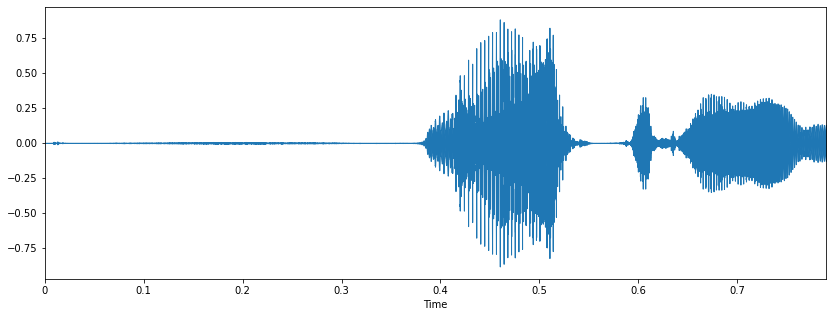

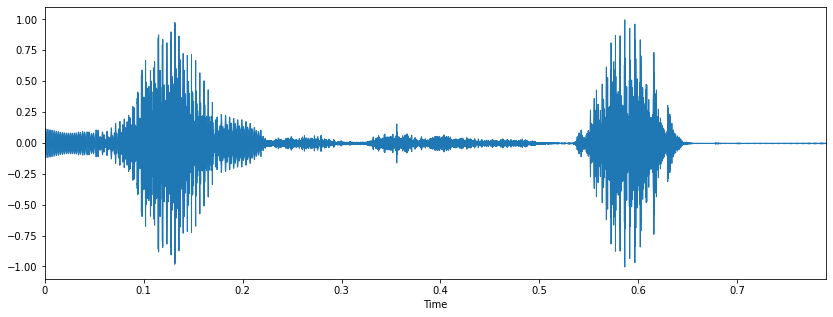

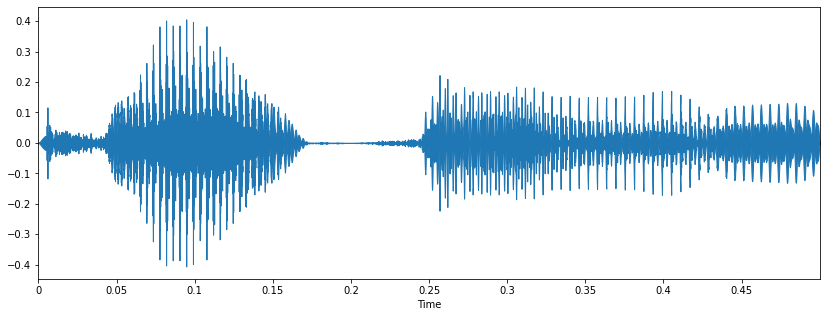

In [25]:
for i in ts:
    start = i[0] * 1000
    stop =  i[1] * 1000
    graph_n_play(data[ms2samples(start,sr):ms2samples(stop,sr)],sr)

In [55]:
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
mypath = "/root/dataset/ASVspoof/LA/ASVspoof2019_LA_train/flac/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
res = {}
# name = []
# timestamp = []
for file in tqdm(onlyfiles):
    data, sr = sf.read(join(mypath, file))
    lfcc = VectorDataSource(data=extract_lfcc(sig=data,sr=sr),scope=20)   
    lfcc.rewind()
    tokens = tokenizer.tokenize(lfcc)
    ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
    res[file] = ts
    # name.append(file)
    # timestamp.append(ts)
# print(res)

100%|██████████| 25380/25380 [1:22:34<00:00,  5.12it/s]


In [6]:
# import pandas as pd
# df = pd.DataFrame.from_dict({'name':name, "timestamp":timestamp})
# print(df.loc[df['name']=="LA_T_2156280.flac"])

proto_path = "/root/dataset/ASVspoof/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
proto = {}
with open(proto_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        detail = line.split(" ")
        proto["{}.flac".format(detail[1])] = detail[-1]

for key, value in res.items():
    if value:
        if proto[key].strip()=='spoof':
            print(key, value, proto[key])

LA_T_5097581.flac [(0.85, 1.1)] spoof

LA_T_2653765.flac [(0.9400000000000001, 1.3900000000000001)] spoof

LA_T_2156280.flac [(0.19, 0.5)] spoof

LA_T_4578357.flac [(1.05, 1.36)] spoof

LA_T_6436778.flac [(0.0, 0.53), (1.53, 1.8)] spoof

LA_T_3494227.flac [(0.0, 0.5700000000000001)] spoof

LA_T_3460794.flac [(0.0, 1.44), (2.2, 2.62)] spoof

LA_T_1561697.flac [(1.08, 1.29)] spoof

LA_T_4835140.flac [(0.0, 0.23), (1.28, 1.81)] spoof

LA_T_5379096.flac [(2.04, 2.23)] spoof

LA_T_8648024.flac [(1.46, 1.74)] spoof

LA_T_8522587.flac [(0.65, 1.01)] spoof

LA_T_2536131.flac [(0.0, 0.63), (1.4000000000000001, 1.95)] spoof

LA_T_7106477.flac [(0.0, 0.7000000000000001), (1.23, 1.6500000000000001), (1.99, 2.2600000000000002)] spoof

LA_T_4775956.flac [(0.14, 0.5700000000000001), (1.56, 1.93)] spoof

LA_T_4415114.flac [(0.01, 0.8300000000000001), (1.62, 2.12)] spoof

LA_T_3103653.flac [(0.01, 0.54), (1.84, 2.22)] spoof

LA_T_1694645.flac [(0.01, 0.63), (1.6600000000000001, 2.27)] spoof

LA_T_63914

# t-SNE

In [74]:
from sklearn.manifold import TSNE
# from tsnecuda import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd  
import torch
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
#asvspoof2021/LA/Baseline-RawNet2-bio/feats

In [75]:

mypath = "/root/biological/asvspoof2021/LA/Baseline-RawNet2-bio/feats/eval_2019/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
df = pd.read_csv('/root/dataset/ASVspoof/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt', sep=' ')
df.columns = ["sid", "utt", "phy", "attack", "class"]
# print(onlyfiles)

In [76]:


feat = pd.DataFrame()
# feat.columns = ["utt", "feats"]

for f in tqdm(onlyfiles):
    # print(f)
    bio_inp = torch.load(join(mypath, f)).cpu().detach().numpy()
    feat = feat.append({"utt": f, "feats": bio_inp}, ignore_index=True)
    # print(bio_inp)
    
feat.head()


100%|██████████| 71237/71237 [03:41<00:00, 322.26it/s]


,feats,utt
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",LA_E_3311139
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",LA_E_3486569
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",LA_E_1374468
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",LA_E_3910014
4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",LA_E_9742234


In [6]:
full = df.join(feat.set_index('utt'), on="utt")

In [7]:
full.head()

,sid,utt,phy,attack,class,feats
0,LA_0014,LA_E_8877452,-,A14,spoof,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LA_0040,LA_E_6828287,-,A16,spoof,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,LA_0022,LA_E_6977360,-,A09,spoof,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,LA_0031,LA_E_5932896,-,A13,spoof,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
4,LA_0030,LA_E_5849185,-,-,bonafide,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## TTS Only

In [24]:
tts_full = full.loc[~full["attack"].str.contains("A17") & ~full["attack"].str.contains("A18") & ~full["attack"].str.contains("A19")]
tts_full.head()


,sid,utt,phy,attack,class,feats
0,LA_0014,LA_E_8877452,-,A14,spoof,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LA_0040,LA_E_6828287,-,A16,spoof,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,LA_0022,LA_E_6977360,-,A09,spoof,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,LA_0031,LA_E_5932896,-,A13,spoof,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
4,LA_0030,LA_E_5849185,-,-,bonafide,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [128]:
x = tts_full["feats"].to_list()
y = tts_full["class"].to_list()

## VC only

In [120]:
vc_full = full.loc[full["attack"].str.contains("A17") | full["attack"].str.contains("A18") | full["attack"].str.contains("A19") | full["attack"].str.contains("-")]
vc_full.head()

,sid,utt,phy,attack,class,feats
4,LA_0030,LA_E_5849185,-,-,bonafide,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,LA_0033,LA_E_4581379,-,-,bonafide,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,LA_0048,LA_E_9157999,-,A18,spoof,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
13,LA_0042,LA_E_1837629,-,A17,spoof,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
14,LA_0039,LA_E_6314733,-,-,bonafide,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [121]:
x = vc_full["feats"].to_list()
y = vc_full["class"].to_list()

In [56]:
x = full["feats"].to_list()
y = full["class"].to_list()

In [129]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
# tsne = TSNE(n_components=2, perplexity=15, learning_rate=10)
z = tsne.fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 56494 samples in 3.089s...
[t-SNE] Computed neighbors for 56494 samples in 1698.937s...
[t-SNE] Computed conditional probabilities for sample 1000 / 56494
[t-SNE] Computed conditional probabilities for sample 2000 / 56494
[t-SNE] Computed conditional probabilities for sample 3000 / 56494
[t-SNE] Computed conditional probabilities for sample 4000 / 56494
[t-SNE] Computed conditional probabilities for sample 5000 / 56494
[t-SNE] Computed conditional probabilities for sample 6000 / 56494
[t-SNE] Computed conditional probabilities for sample 7000 / 56494
[t-SNE] Computed conditional probabilities for sample 8000 / 56494
[t-SNE] Computed conditional probabilities for sample 9000 / 56494
[t-SNE] Computed conditional probabilities for sample 10000 / 56494
[t-SNE] Computed conditional probabilities for sample 11000 / 56494
[t-SNE] Computed conditional probabilities for sample 12000 / 56494
[t-SNE] Computed conditional probabilities for 

In [133]:
y = tts_full["attack"].replace("A17", "VC").replace("A18", "VC").replace("A19", "VC").replace("A07", "TTS").replace("A08", "TTS").replace("A09", "TTS").replace("A10", "TTS").replace("A11", "TTS").replace("A12", "TTS").replace("A13", "TTS").replace("A14", "TTS").replace("A15", "TTS").replace("A16", "TTS").replace("-","bonafide")


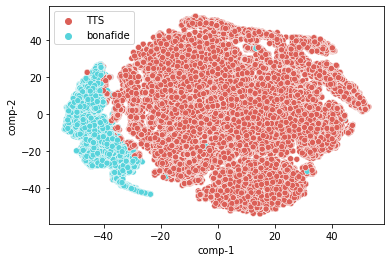

In [136]:
dff = pd.DataFrame()
dff["y"] = y
dff["comp-1"] = z[:,0]
dff["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=dff.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=dff).set(title="") 
plt.savefig('tts_and_bonafide.png',dpi=600)

## RNN encoding feature space


In [107]:
path = "/root/biological/asvspoof2021/LA/Baseline-RawNet2-bio/bio_encoding/tts_only/rnn_32concat/"
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
tfeat = pd.DataFrame()
# feat.columns = ["utt", "feats"]

for f in tqdm(files):
    bio_enc = torch.load(join(path, f))
    # print(bio_enc)
    tfeat = tfeat.append({"utt": f, "tfeat": bio_enc}, ignore_index=True)

tfull = df.join(tfeat.set_index('utt'), on="utt")
tfull.head()

100%|██████████| 71237/71237 [03:42<00:00, 320.21it/s]


,sid,utt,phy,attack,class,tfeat
0,LA_0014,LA_E_8877452,-,A14,spoof,"[0.07591550052165985, -0.0003693430917337537, ..."
1,LA_0040,LA_E_6828287,-,A16,spoof,"[0.07303798198699951, -0.0003675650805234909, ..."
2,LA_0022,LA_E_6977360,-,A09,spoof,"[0.07458335906267166, -0.0003687691641971469, ..."
3,LA_0031,LA_E_5932896,-,A13,spoof,"[0.07667844742536545, -0.00036962420563213527,..."
4,LA_0030,LA_E_5849185,-,-,bonafide,"[-0.0740271508693695, -0.00017428226419724524,..."


In [108]:
x = tfull["tfeat"].to_list()
y = tfull["attack"].replace("A17", "VC").replace("A18", "VC").replace("A19", "VC").replace("A07", "TTS").replace("A08", "TTS").replace("A09", "TTS").replace("A10", "TTS").replace("A11", "TTS").replace("A12", "TTS").replace("A13", "TTS").replace("A14", "TTS").replace("A15", "TTS").replace("A16", "TTS")


tsne = TSNE(n_components=2, verbose=1, random_state=40)
z = tsne.fit_transform(x) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 71236 samples in 11.778s...
[t-SNE] Computed neighbors for 71236 samples in 51.936s...
[t-SNE] Computed conditional probabilities for sample 1000 / 71236
[t-SNE] Computed conditional probabilities for sample 2000 / 71236
[t-SNE] Computed conditional probabilities for sample 3000 / 71236
[t-SNE] Computed conditional probabilities for sample 4000 / 71236
[t-SNE] Computed conditional probabilities for sample 5000 / 71236
[t-SNE] Computed conditional probabilities for sample 6000 / 71236
[t-SNE] Computed conditional probabilities for sample 7000 / 71236
[t-SNE] Computed conditional probabilities for sample 8000 / 71236
[t-SNE] Computed conditional probabilities for sample 9000 / 71236
[t-SNE] Computed conditional probabilities for sample 10000 / 71236
[t-SNE] Computed conditional probabilities for sample 11000 / 71236
[t-SNE] Computed conditional probabilities for sample 12000 / 71236
[t-SNE] Computed conditional probabilities for s

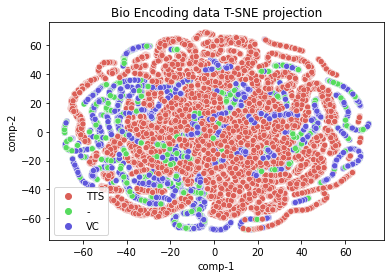

In [109]:
dff = pd.DataFrame()
dff["y"] = y
dff["comp-1"] = z[:,0]
dff["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=dff.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=dff).set(title="Bio Encoding data T-SNE projection") 
import matplotlib.pyplot as plt
plt.savefig('rnn_64concat_tts.png',dpi=600)

# Ori Rawnet2


In [115]:
path = "/root/biological/asvspoof2021/LA/Baseline-RawNet2/bio_encoding/last_x/"
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
tfeat = pd.DataFrame()
# feat.columns = ["utt", "feats"]

for f in tqdm(files):
    bio_enc = torch.load(join(path, f))
    # print(bio_enc)
    tfeat = tfeat.append({"utt": f, "tfeat": bio_enc}, ignore_index=True)

tfull = df.join(tfeat.set_index('utt'), on="utt")
tfull.head()

100%|██████████| 71237/71237 [03:26<00:00, 344.30it/s]


,sid,utt,phy,attack,class,tfeat
0,LA_0014,LA_E_8877452,-,A14,spoof,"[-0.02183333970606327, -0.03265954554080963]"
1,LA_0040,LA_E_6828287,-,A16,spoof,"[-0.02182806469500065, -0.032662201672792435]"
2,LA_0022,LA_E_6977360,-,A09,spoof,"[-0.021840190514922142, -0.0326438844203949]"
3,LA_0031,LA_E_5932896,-,A13,spoof,"[-0.021828221157193184, -0.032650627195835114]"
4,LA_0030,LA_E_5849185,-,-,bonafide,"[-0.021830106154084206, -0.03264375776052475]"


In [116]:
x = tfull["tfeat"].to_list()
y = tfull["attack"].replace("A17", "VC").replace("A18", "VC").replace("A19", "VC").replace("A07", "TTS").replace("A08", "TTS").replace("A09", "TTS").replace("A10", "TTS").replace("A11", "TTS").replace("A12", "TTS").replace("A13", "TTS").replace("A14", "TTS").replace("A15", "TTS").replace("A16", "TTS")


tsne = TSNE(n_components=2, verbose=1, random_state=40)
z = tsne.fit_transform(x) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 71236 samples in 0.025s...
[t-SNE] Computed neighbors for 71236 samples in 0.944s...
[t-SNE] Computed conditional probabilities for sample 1000 / 71236
[t-SNE] Computed conditional probabilities for sample 2000 / 71236
[t-SNE] Computed conditional probabilities for sample 3000 / 71236
[t-SNE] Computed conditional probabilities for sample 4000 / 71236
[t-SNE] Computed conditional probabilities for sample 5000 / 71236
[t-SNE] Computed conditional probabilities for sample 6000 / 71236
[t-SNE] Computed conditional probabilities for sample 7000 / 71236
[t-SNE] Computed conditional probabilities for sample 8000 / 71236
[t-SNE] Computed conditional probabilities for sample 9000 / 71236
[t-SNE] Computed conditional probabilities for sample 10000 / 71236
[t-SNE] Computed conditional probabilities for sample 11000 / 71236
[t-SNE] Computed conditional probabilities for sample 12000 / 71236
[t-SNE] Computed conditional probabilities for sam

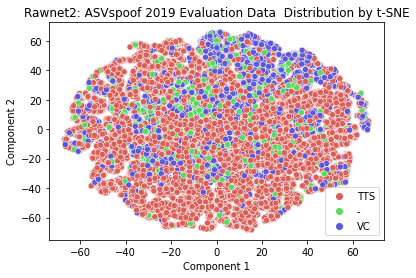

In [117]:
dff = pd.DataFrame()
dff["y"] = y
dff["Component 1"] = z[:,0]
dff["Component 2"] = z[:,1]

sns.scatterplot(x="Component 1", y="Component 2", hue=dff.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=dff).set(title="Rawnet2: ASVspoof 2019 Evaluation Data  Distribution by t-SNE")
import matplotlib.pyplot as plt
plt.savefig('ori_last_x.png',dpi=600)

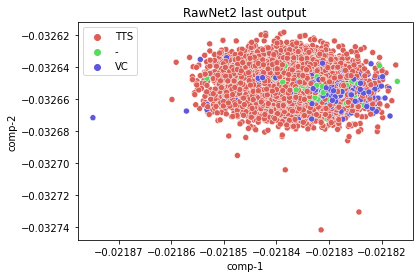

In [118]:
dff = pd.DataFrame()
split_df = pd.DataFrame(tfull["tfeat"].tolist(), columns=['v1', 'v2'])

dff["y"] = y
dff["comp-1"] = split_df['v1']
dff["comp-2"] = split_df['v2']

sns.scatterplot(x="comp-1", y="comp-2", hue=dff.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=dff).set(title="RawNet2 last output") 
plt.savefig('ori_last_x.png',dpi=600)

In [110]:
path = "/root/biological/asvspoof2021/LA/Baseline-RawNet2/bio_encoding/after_gru/"
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
tfeat = pd.DataFrame()
# feat.columns = ["utt", "feats"]

for f in tqdm(files):
    bio_enc = torch.load(join(path, f))
    # print(bio_enc)
    tfeat = tfeat.append({"utt": f, "tfeat": bio_enc}, ignore_index=True)

tfull = df.join(tfeat.set_index('utt'), on="utt")
tfull.head()

100%|██████████| 71237/71237 [03:44<00:00, 317.64it/s]


,sid,utt,phy,attack,class,tfeat
0,LA_0014,LA_E_8877452,-,A14,spoof,"[-0.0002935427473857999, -0.09794993698596954,..."
1,LA_0040,LA_E_6828287,-,A16,spoof,"[-0.0002717380993999541, -0.08989518880844116,..."
2,LA_0022,LA_E_6977360,-,A09,spoof,"[-0.0002956722164526582, -0.09465887397527695,..."
3,LA_0031,LA_E_5932896,-,A13,spoof,"[-0.00028330436907708645, -0.0941389873623848,..."
4,LA_0030,LA_E_5849185,-,-,bonafide,"[0.0002146959595847875, 0.05150444805622101, 2..."


In [113]:
x = tfull["tfeat"].to_list()
y = tfull["attack"].replace("A17", "VC").replace("A18", "VC").replace("A19", "VC").replace("A07", "TTS").replace("A08", "TTS").replace("A09", "TTS").replace("A10", "TTS").replace("A11", "TTS").replace("A12", "TTS").replace("A13", "TTS").replace("A14", "TTS").replace("A15", "TTS").replace("A16", "TTS")


tsne = TSNE(n_components=2, verbose=1, random_state=40)
z = tsne.fit_transform(x) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 71236 samples in 16.365s...
[t-SNE] Computed neighbors for 71236 samples in 54.605s...
[t-SNE] Computed conditional probabilities for sample 1000 / 71236
[t-SNE] Computed conditional probabilities for sample 2000 / 71236
[t-SNE] Computed conditional probabilities for sample 3000 / 71236
[t-SNE] Computed conditional probabilities for sample 4000 / 71236
[t-SNE] Computed conditional probabilities for sample 5000 / 71236
[t-SNE] Computed conditional probabilities for sample 6000 / 71236
[t-SNE] Computed conditional probabilities for sample 7000 / 71236
[t-SNE] Computed conditional probabilities for sample 8000 / 71236
[t-SNE] Computed conditional probabilities for sample 9000 / 71236
[t-SNE] Computed conditional probabilities for sample 10000 / 71236
[t-SNE] Computed conditional probabilities for sample 11000 / 71236
[t-SNE] Computed conditional probabilities for sample 12000 / 71236
[t-SNE] Computed conditional probabilities for s

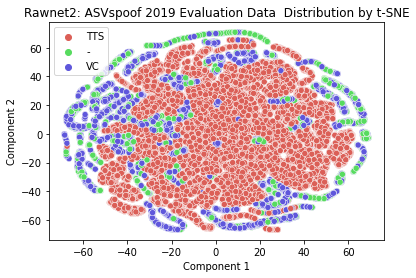

In [114]:
dff = pd.DataFrame()
dff["y"] = y
dff["Component 1"] = z[:,0]
dff["Component 2"] = z[:,1]

sns.scatterplot(x="Component 1", y="Component 2", hue=dff.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=dff).set(title="Rawnet2: ASVspoof 2019 Evaluation Data  Distribution by t-SNE")
import matplotlib.pyplot as plt
plt.savefig('test.png',dpi=600)

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter 

In [138]:
df = pd.read_csv("ori.csv")
df = df.set_index('epoch')
df = df.apply(savgol_filter,  window_length=15, polyorder=3)

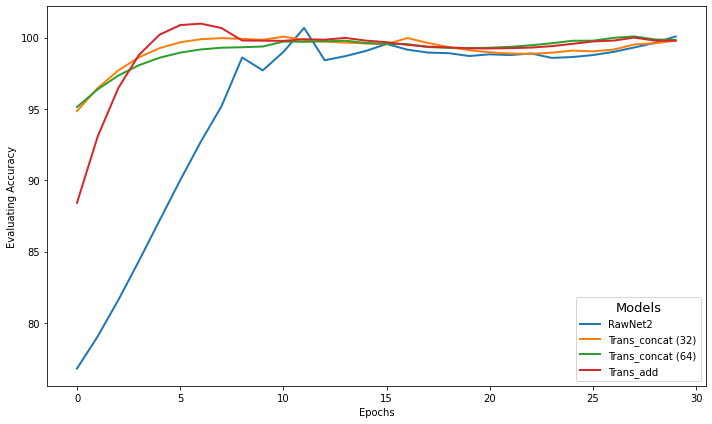

In [140]:
plt.figure(figsize=(10,6), tight_layout=True)
#plotting
plt.plot(df[:30], linewidth=2)
#customization
# plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
plt.xlabel('Epochs')
plt.ylabel('Evaluating Accuracy')
plt.title('')
plt.legend(title='Models', title_fontsize = 13, labels=['RawNet2', 'Trans_concat (32)','Trans_concat (64)', 'Trans_add'])
# plt.show()
plt.savefig('conver_speed.png',dpi=600)

# ML apply

## Random forest


In [142]:
tts_full.head()

,sid,utt,phy,attack,class,feats
0,LA_0014,LA_E_8877452,-,A14,spoof,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LA_0040,LA_E_6828287,-,A16,spoof,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,LA_0022,LA_E_6977360,-,A09,spoof,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,LA_0031,LA_E_5932896,-,A13,spoof,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
4,LA_0030,LA_E_5849185,-,-,bonafide,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
